# Landsat Surface Temperature <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[ls5_st](https://explorer.digitalearth.africa/ls5_st),
[ls7_st](https://explorer.digitalearth.africa/ls7_st),
[ls8_st](https://explorer.digitalearth.africa/ls8_st)

## Background

The United States Geological Survey's (USGS) [Landsat satellite program](https://www.nasa.gov/mission_pages/landsat/overview/index.html) has been capturing images of the African continent for more than 30 years. These data are highly useful for land and coastal mapping studies. The Landsat mission not only collects surface reflectance data, but also surface temperature.

Surface temperature measures the Earth’s surface temperature (units of Kelvin) and is an important geophysical parameter in global energy balance studies and hydrologic modeling. Surface temperature is also useful for monitoring crop and vegetation health, and extreme heat events such as natural disasters (e.g. volcanic eruptions, wildfires), and urban heat island effects.

The surface temperature product is generated from:

* Landsat Collection 2 Level-1 thermal infrared bands
* Top of Atmosphere (TOA) reflectance
* TOA brightness temperature
* Advanced Spaceborne Thermal Emission and Reflection Radiometer (ASTER) Global Emissivity Database (GED) data
* ASTER Normalised Difference Vegetation Index (NDVI) data
* Atmospheric profiles of geopotential height, specific humidity, and air temperature extracted from:
    * Acquisitions 2000 to present: Goddard Earth Observing System (GEOS) Model , Version 5, Forward Processing Instrument Teams (FP-IT) 
    * Acquisitions 1982 to 1999: Modern Era Retrospective analysis for Research and Applications Version 2 (MERRA-2) 

For more information and caveats of the product, visit the Landsat Science Products Overview and the [Landsat Surface Temperature webpage](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2-surface-temperature#:~:text=Landsat%20surface%20temperature%20measures%20the,balance%20studies%20and%20hydrologic%20modeling.).

**Important details:**

* Surface temperature product
    * Native scaling range: `1 - 65,535` (`0` is `no-data`)
    * To achieve surface temperature values, convert the values to Kelvin using `ds = ds * 0.00341802 + 149.0`
    * Using `dc.load` will load data in the native scaling range `1 - 65,535`, while using `load_ard` will convert to Kelvin
* Native pixel alignment is `centre`
* Date-range: 1984 &ndash; present
* Spatial resolution: 30 x 30 m

> The surface temperature product is provided at 30 m spatial sampling, however, the thermal sensors vary in spectral response, sensitivity and resolution.

For a detailed description of DE Africa's Landsat archive, see the DE Africa's [Landsat surface temperature technical specifications documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_C2_ST_specs.html).

## Description

This notebook demonstrates how to load and use the Land Surface Temperature product from the Landsat Collection 2 dataset. Topics covered include:

1. Load surface temperature and filter with quality assessment
2. Compare mean surface temperature to daily air temperature at 2-meters height from ERA5
3. Inspect related land surface characteristics

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landsat_Surface_Temperature")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's Landsat products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

> We can search for Landsat Collection 2 Surface Temperature data by using the search term `_st`. `st` stands for "surface temperature". The datacube is case-sensitive so this must be typed in lower case.

In [3]:
# List Landsat products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    '_st').fillna(
        False)][display_columns].set_index('name')

,description
name,
ls5_st,USGS Landsat 5 Collection 2 Level-2 Surface Te...
ls7_st,USGS Landsat 7 Collection 2 Level-2 Surface Te...
ls8_st,USGS Landsat 8 Collection 2 Level-2 Surface Te...
ls9_st,USGS Landsat 9 Collection 2 Level-2 Surface Te...


### List measurements

We can further inspect the data available for each Landsat product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

> Note that Landsat 8 surface temperature products are generated with a different algorithm from Landsat 5 and 7. It therefore has different output measurements.

In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['ls8_st']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
ST_B10,ST_B10,uint16,Kelvin,0.0,"[band_10, st, surface_temperature]",NaN
ST_TRAD,ST_TRAD,int16,W/(m2.sr.μm),-9999.0,"[trad, thermal_radiance]",NaN
ST_URAD,ST_URAD,int16,W/(m2.sr.μm),-9999.0,"[urad, upwell_radiance]",NaN
ST_DRAD,ST_DRAD,int16,W/(m2.sr.μm),-9999.0,"[drad, downwell_radiance]",NaN
ST_ATRAN,ST_ATRAN,int16,1,-9999.0,"[atran, atmospheric_transmittance]",NaN
ST_EMIS,ST_EMIS,int16,1,-9999.0,"[emis, emissivity]",NaN
ST_EMSD,ST_EMSD,int16,1,-9999.0,"[emsd, emissivity_stddev]",NaN
ST_CDIST,ST_CDIST,int16,Kilometers,-9999.0,"[cdist, cloud_distance]",NaN
QA_PIXEL,QA_PIXEL,uint16,bit_index,1.0,"[pq, pixel_quality]","{'snow': {'bits': 5, 'values': {'0': 'not_high..."


## Load Landsat surface temperature using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load surface temperature data from Landsat 8 for Namibia, across parts of 2018 and 2019. First, we will set up the parameters of our data load: latitude and longitude, time, and band measurements.

By specifying `output_crs='EPSG:32633'` and `resolution=(-30, 30)`, we request that datacube reproject our data to the desired Coordinate Reference System (CRS), with 30 x 30 m pixels. 

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.


In [5]:
# Define the analysis region (Lat-Lon box)
# High Energy Stereoscopic System site near Windhoek Namibia
lat = (-23.275, -23.265)
lon = (16.495, 16.505)

# Define the time window
time = ('2018-07-01', '2019-05-31')

# Load land surface temperature and quality assessment
# We can use the alias names to call the bands 
measurements = ['surface_temperature', 'surface_temperature_quality']

In [6]:
data = dc.load(product='ls8_st',
               x=lon,
               y=lat,
               time=time,
               measurements = measurements,
               output_crs = 'EPSG:32633',
               resolution = (-30, 30))

print(data)

<xarray.Dataset>
Dimensions:                      (time: 21, y: 38, x: 36)
Coordinates:
  * time                         (time) datetime64[ns] 2018-07-14T08:50:08.03...
  * y                            (y) float64 -2.574e+06 ... -2.575e+06
  * x                            (x) float64 6.529e+05 6.529e+05 ... 6.54e+05
    spatial_ref                  int32 32633
Data variables:
    surface_temperature          (time, y, x) uint16 37304 37301 ... 44135 44172
    surface_temperature_quality  (time, y, x) int16 634 635 634 ... 175 177 178
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref


### Plotting Landsat data from dc.load

We can plot the data we loaded for each timestep and inspect it.


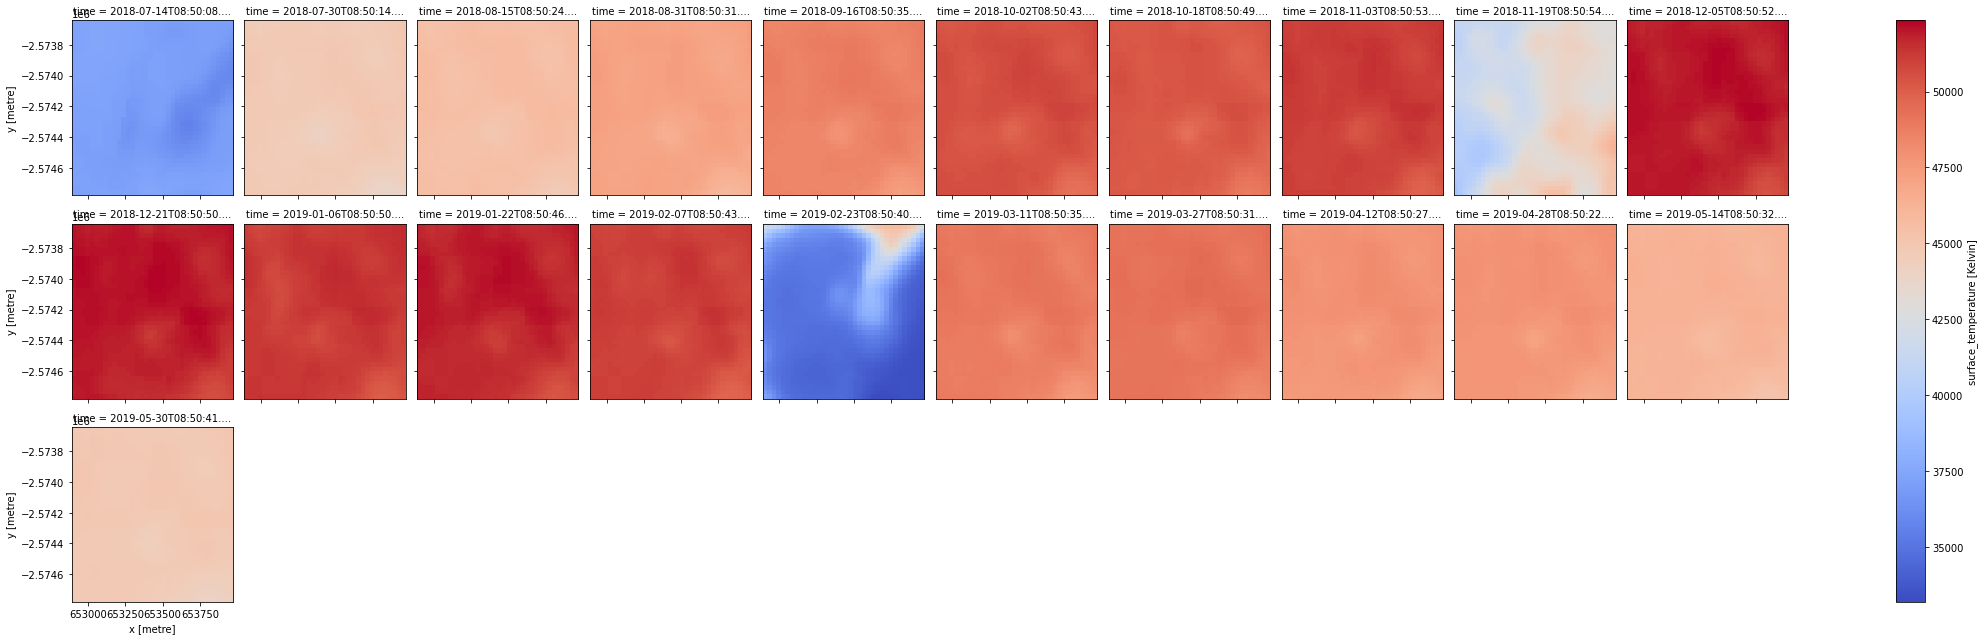

In [7]:
data.surface_temperature.plot.imshow(col='time', col_wrap=10, cmap='coolwarm');

Notice the scale of surface temperature is very large. This is because the data loaded with `dc.load` has not been scaled according to the scale factor and offsets determined by USGS. Loading data with `load_ard` performs that scaling automatically, to give temperature in Kelvin.

## Load Landsat using `load_ard`

`load_ard` applies the linear scaling and offset which converts the native loaded data to actual surface temperature values. `load_ard` will additionally concatenate and sort the observations by time, and apply a cloud mask. The result is an analysis-ready dataset, which is much easier to use.

In the example below, we load Landsat 8 data for the same time and place as above. We will call this dataset `ds` to distinguish it from the previously-loaded dataset. Note a cloud mask has now been applied. `load_ard` also converts the temperature data into Kelvin.

You can find more information on the `load_ard` function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [8]:
ds = load_ard(dc=dc,
               products=['ls8_st'],
               x=lon,
               y=lat,
               time=time,
               measurements = measurements,
               output_crs = 'EPSG:32633',
               resolution = (-30, 30))

print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 21 time steps
<xarray.Dataset>
Dimensions:                      (time: 21, y: 38, x: 36)
Coordinates:
  * time                         (time) datetime64[ns] 2018-07-14T08:50:08.03...
  * y                            (y) float64 -2.574e+06 ... -2.575e+06
  * x                            (x) float64 6.529e+05 6.529e+05 ... 6.54e+05
    spatial_ref                  int32 32633
Data variables:
    surface_temperature          (time, y, x) float32 nan nan ... 299.9 300.0
    surface_temperature_quality  (time, y, x) float32 nan nan nan ... 1.77 1.78
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref


We now want to drop empty slices and convert the `surface_temperature` band to degrees Celsius. We then plot the time slices with valid data.

In [9]:
ds = ds.dropna(dim='time', how='all')
ds['surface_temperature'] = ds.surface_temperature - 273.15

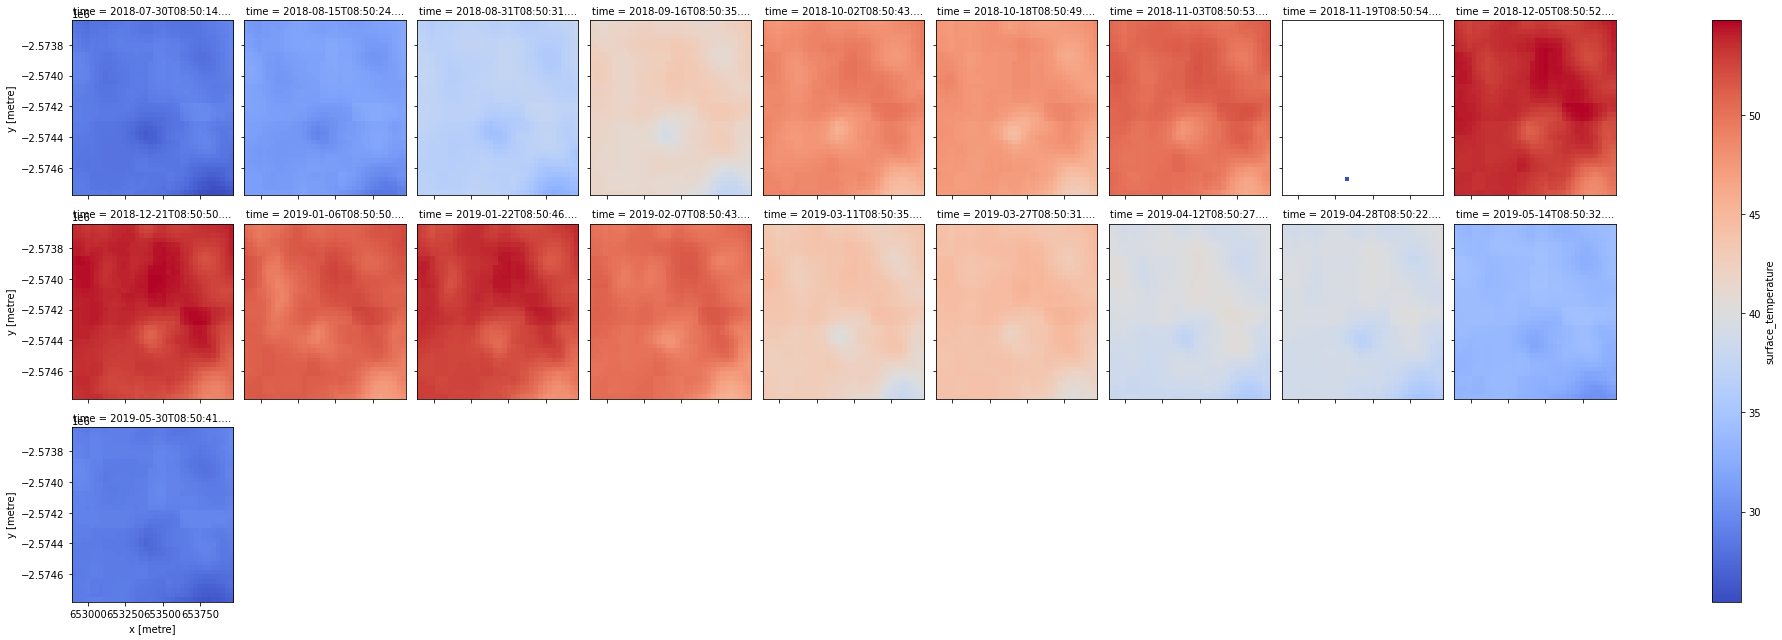

In [10]:
ds.surface_temperature.plot.imshow(col='time', col_wrap=9, cmap='coolwarm');

## Compare mean surface temperature to daily air temperature

We can load some ERA5 atmospheric data to compare with the Landsat 8 mean surface temperature. Here we use ERA5 daily air temperature at 2 metres height. It is loaded using the `load_era5` function and then converted into degrees Celsius. For more information on the ERA5 data and how it is loaded into the Sandbox, see the [Climate Data ERA5](./Climate_Data_ERA5_AWS.ipynb) notebook.

To plot the data together, we find the average of the land surface temperature over our selected area. This can then be shown together with the corresponding 2-metre air temperature data.

In [11]:
# Load ERA5 air temperature at 2 m height
var = 'air_temperature_at_2_metres'

air_temp = load_era5(var, lat, lon, time, reduce_func=np.mean)[var] - 273.15

In [12]:
ds_mean = ds.groupby('time').mean(dim=xr.ALL_DIMS)

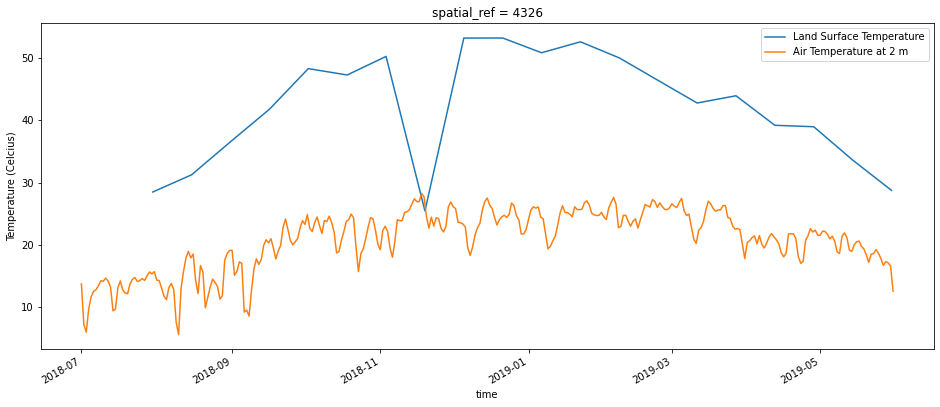

In [13]:
ds_mean.surface_temperature.plot(figsize = (16, 6),label='Land Surface Temperature');
air_temp.groupby('time').mean(dim=xr.ALL_DIMS).plot(label='Air Temperature at 2 m');
plt.ylabel('Temperature (Celcius)')
plt.legend()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.7


**Last Tested:**

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-06-21'